# CNN-lytical Assignment-1
*  In this assignment, we will build a classifier for MNIST from scratch using just [NumPy](https://numpy.org/)

*  [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits of size 28x28

*  The dataset that you are expected to use for training can be found [here](https://drive.google.com/file/d/1z7lwIml6UxsNpDIW3_mPPEb8SoaPC5Zg/view)

*   Our model will have 1 hidden layer, like the one below (not our recommendation to use 256 in the hidden layer though, try various values out)

**Feel free to redefine any function signatures below, just make sure the final cell remains the same.**

<center>
<img src="https://user-images.githubusercontent.com/81357954/166119893-4ca347b8-b1a4-40b8-9e0a-2e92b5f164ae.png">
</center>

## Import libraries here
NumPy, Matplotlib, ...

Also remember to initialize the seed for reproducibility of results

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import StratifiedShuffleSplit
import copy

np.random.seed(1337)

## Load *Dataset*
Load data from the given pickle file

In [3]:
# mount Google Drive to access the dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# load the data set
train_data_path = "/content/drive/MyDrive/CNN-lytical/MNIST/train_data.pkl"
with open(train_data_path, 'rb') as train_data_pickle:
  train_data = pickle.load(train_data_pickle)

In [5]:
# print the shapes of the data
print(train_data['X'].shape)
print(train_data['y'].shape)

(60000, 784)
(60000, 1)


In [6]:
X = train_data['X']
y = np.squeeze(train_data['y'])

# Split into X_train, y_train, X_test, y_test
# you can use stratified splitting from sklearn library
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2)
for train_index, test_index in sss.split(X, y):
  X_train, y_train = X[train_index], y[train_index]
  X_test, y_test = X[test_index], y[test_index]

# Print shapes
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

X_train: (48000, 784)
y_train: (48000,)
X_test: (12000, 784)
y_test: (12000,)


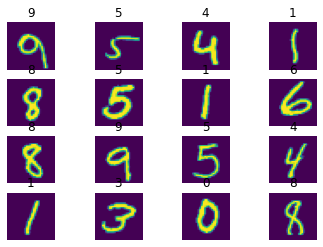

In [7]:
# display a 4x4 grid, 
# choose 16 images randomly, display the images as well as corresponding labels
for i in range(1, 17):
  plt.subplot(4, 4, i)
  idx = np.random.randint(X_train.shape[0])
  plt.title(y_train[idx])
  plt.axis('off')
  plt.imshow(X_train[idx].reshape(28, 28))

In [8]:
# normalize
#epsilon = 1e-8
#X_mean = np.mean(X, axis=0, keepdims=True)
#X_std = np.std(X, axis=0, keepdims=True)
#X_train = (X_train - X_mean)/(X_std + epsilon)
#X_test = (X_test - X_mean)/(X_std + epsilon)
X_train = (X_train - np.mean(X_train, axis=1, keepdims=True))/np.std(X_train, axis=1, keepdims=True)
X_test = (X_test - np.mean(X_test, axis=1, keepdims=True))/np.std(X_test, axis=1, keepdims=True)

print("X_train:", X_train.shape)
print("y_train:", y_train.shape)

X_train: (48000, 784)
y_train: (48000,)


## Building up parts of our classifier

**Activation functions**

In [9]:
def relu(z):
    """
    Arguments:
    z -- A scalar or numpy array.
    Return:
    relu func applied to each element of z
    """
    result = copy.deepcopy(z)
    result[result <= 0] = 0
    return result

def softmax(z):
    """
    returns computed probabilitites for each element in batch separately
    input: (N, 10)
    output: (N, 10)
    """
    result = copy.deepcopy(z)
    result = np.exp(result)
    result = result / np.sum(result, axis=1, keepdims=True)
    return result

**Notes about the Neural Network** 
*   Input size is (784,) because 28x28 = 784
*   Output size will be 10, each element represeting probability of the image representing that digit
*   Size of the hidden layer is a hyperparameter



**Initialize the layers weights**

Generally, we follow the convention that weights are drawn from a standard normal distribution, while the bias vectors are initialized to zero. But you can try everything out :)

In [10]:
def init_params(layer0_len, layer1_len, layer2_len):
    """
    ideally it should take the size of all the layers and 
    should return the initialized weights.
    """
    W1 = 0.01 * np.random.randn(layer0_len, layer1_len)
    b1 = np.zeros((1, layer1_len))
    W2 = 0.01 * np.random.randn(layer1_len, layer2_len)
    b2 = np.zeros((1, layer2_len))

    return {"W1": W1, "b1": b1, "W2": W2, "b2": b2}

**Forward Propagation**

The equations used for forward propagation here are:
\begin{align}
z_1 &= X \cdot W_1 + b_1 \\
a_1 &= \text{ReLU}(z_1) \\
z_2 &= a_1 \cdot W_2 + b_2 \\
a_2 &= \text{softmax}(z_2)
\end{align}

In [11]:
def forward_propg(X, weights):
    """
    X: input data
    returns: logits, output of each layer z1,z2,a1,a2
    """
    W1 = weights["W1"]
    W2 = weights["W2"]
    b1 = weights["b1"]
    b2 = weights["b2"]

    z1 = np.dot(X, W1) + b1
    a1 = relu(z1)
    z2 = np.dot(a1, W2) + b2
    a2 = softmax(z2)

    return {"z1": z1, "z2": z2, "a1": a1, "a2": a2}

**Backward Propagation**


You may use stochastic gradient descent or batch gradient descent here. Feel free to use any loss function.

The equations used for backward propagation here are:
\begin{align}
  dz_{2_k} &= \dfrac{1}{N}(a_{2_k} - \mathbf{1}(k == y_i)) \\
  dW_2 &= a_1^T \cdot dz_2 + \lambda W_2\\
  db_2 &= \text{np.sum}(dz_2, \text{axis}=0, \text{keepdims}=\text{True}) \\
  da_1 &= dz_2 \cdot W_2^T \\
  dz_{1_k} &= \begin{cases} 0 & \text{if } a_{1_k} \le 0 \\ a_{1_k} & \text{otherwise}\end{cases} \\ 
  dW_1 &= X^T \cdot dz_1 + \lambda W_1\\
  db_1 &= \text{np.sum}(dz_1, \text{axis}=0, \text{keepdims}=\text{True})
\end{align}

In [23]:
def backward_propg(weights, X, y, cache, lamb, lr):
    """
    should update the weights and return updated weights
    """
    W1 = weights["W1"]
    W2 = weights["W2"]
    b1 = weights["b1"]
    b2 = weights["b2"]

    z1 = cache["z1"]
    z2 = cache["z2"]
    a1 = cache["a1"]
    a2 = cache["a2"]

    N = X.shape[0]

    dz2 = a2; dz2[range(N), y] -= 1; dz2 /= N
    dW2 = np.dot(a1.T, dz2) + lamb * W2
    db2 = np.sum(dz2, axis=0, keepdims=True)
    da1 = np.dot(dz2, W2.T)
    dz1 = copy.deepcopy(da1); dz1[a1 <= 0] = 0
    dW1 = np.dot(X.T, dz1) + lamb * W1
    db1 = np.sum(dz1, axis=0, keepdims=True)

    grads = {}
    grads["dW1"] = dW1
    grads["dW2"] = dW2
    grads["db1"] = db1
    grads["db2"] = db2

    return grads

The equation used for the cost function here is:
\begin{align}
  J = \dfrac{1}{N} \sum_i -\log{a_{2_{y_i}}} + \dfrac{1}{2} \lambda \sum_j \sum_k W_{1_{j,k}}^2 + \dfrac{1}{2} \lambda \sum_j \sum_k W_{2_{j,k}}^2
\end{align}

In [13]:
def cost_func(weights, X, y, lamb):
    """
    calculate loss to check whether it is decreasing at each epoch or not
    one can return this in backward propagation as well
    """
    W1 = weights["W1"]
    W2 = weights["W2"]
    b1 = weights["b1"]
    b2 = weights["b2"]

    N = X.shape[0]

    cache = forward_propg(X, weights)
    a2 = cache["a2"]

    correct_logprobs = -np.log(a2[range(N), y])
    data_loss = np.sum(correct_logprobs) / N
    reg_loss = 0.5 * lamb * np.sum(W1 * W1) + 0.5 * lamb * np.sum(W2 * W2)
    cost = data_loss + reg_loss

    return cost


## Integrate everything

In [24]:
def train(X, y, hidden_nodes, epochs=1000, lamb=1e-3, lr=1e-5, mini_batch_size=1024, beta1=0.9, beta2=0.999, epsilon=1e-8):
    """
    hidden_nodes: no. of nodes in hidden layer

    should return the updated optimize weights.
    """
    # initialize weights.
    weights = init_params(X.shape[1], hidden_nodes, 10)

    v = {}; s = {}
    v["dW1"] = np.zeros(weights["W1"].shape); s["dW1"] = np.zeros(weights["W1"].shape)
    v["db1"] = np.zeros(weights["b1"].shape); s["db1"] = np.zeros(weights["b1"].shape)
    v["dW2"] = np.zeros(weights["W2"].shape); s["dW2"] = np.zeros(weights["W2"].shape)
    v["db2"] = np.zeros(weights["b2"].shape); s["db2"] = np.zeros(weights["b2"].shape)

    for i in range(epochs):
        N = X.shape[0]
        permutation = list(np.random.permutation(N))
        shuffled_X = X[permutation]
        shuffled_y = y[permutation]

        mini_batches = []
        num_complete_minibatches = int(N // mini_batch_size)
        for k in range(0, num_complete_minibatches):
          mini_batch_X = shuffled_X[k*mini_batch_size : (k+1)*mini_batch_size]
          mini_batch_Y = shuffled_y[k*mini_batch_size : (k+1)*mini_batch_size]
          mini_batches.append((mini_batch_X, mini_batch_Y))

        for batch_id in range(num_complete_minibatches):
          # forward propagation
          cache = forward_propg(mini_batches[batch_id][0], weights)
          
          # backward propagation
          grads = backward_propg(weights, mini_batches[batch_id][0], mini_batches[batch_id][1], cache, lamb, lr)

          #Adam Gradient Update
          v_corrected = {}; s_corrected = {}
          v["dW1"] = beta1 * v["dW1"] + (1 - beta1) * grads["dW1"]; s["dW1"] = beta2 * s["dW1"] + (1 - beta2) * np.power(grads["dW1"], 2)
          v["db1"] = beta1 * v["db1"] + (1 - beta1) * grads["db1"]; s["db1"] = beta2 * s["db1"] + (1 - beta2) * np.power(grads["db1"], 2)
          v["dW2"] = beta1 * v["dW2"] + (1 - beta1) * grads["dW2"]; s["dW2"] = beta2 * s["dW2"] + (1 - beta2) * np.power(grads["dW2"], 2)
          v["db2"] = beta1 * v["db2"] + (1 - beta1) * grads["db2"]; s["db2"] = beta2 * s["db2"] + (1 - beta2) * np.power(grads["db2"], 2)
          t = i*mini_batch_size + batch_id + 1
          v_corrected["dW1"] = v["dW1"] / (1 - np.power(beta1, t)); s_corrected["dW1"] = s["dW1"] / (1 - np.power(beta2, t))
          v_corrected["db1"] = v["db1"] / (1 - np.power(beta1, t)); s_corrected["db1"] = s["db1"] / (1 - np.power(beta2, t))
          v_corrected["dW2"] = v["dW2"] / (1 - np.power(beta1, t)); s_corrected["dW2"] = s["dW2"] / (1 - np.power(beta2, t))
          v_corrected["db2"] = v["db2"] / (1 - np.power(beta1, t)); s_corrected["db2"] = s["db2"] / (1 - np.power(beta2, t))

          weights["W1"] -= lr * v_corrected["dW1"] / (np.sqrt(s_corrected["dW1"]) + epsilon)
          weights["b1"] -= lr * v_corrected["db1"] / (np.sqrt(s_corrected["db1"]) + epsilon)
          weights["W2"] -= lr * v_corrected["dW2"] / (np.sqrt(s_corrected["dW2"]) + epsilon)
          weights["b2"] -= lr * v_corrected["db2"] / (np.sqrt(s_corrected["db2"]) + epsilon)

        # print cost at every 100 or so iterations
        if((i+1)%10 == 0):
          print("Cost after iteration {}: {}".format(i+1, cost_func(weights, mini_batches[0][0], mini_batches[0][1], lamb)))
    
    return weights

In [15]:
def predict(X, updated_weights):
    """
    returns the prediction in [0,9] for each element in X
    """
    cache = forward_propg(X, updated_weights)
    z2 = cache["z2"]
    predictions = np.argmax(z2, axis=1)

    return predictions

In [16]:
def accuracy(predictions, y):
    """
    prints % accuracy
    """
    print("Accuracy: {}%".format(np.mean(predictions == y) * 100))

In [35]:
num_hidden_nodes = 40
model_weights = train(X_train, y_train, num_hidden_nodes, epochs=100, lamb=1e-3, lr=1e-2)

Cost after iteration 10: 0.18747848132622058
Cost after iteration 20: 0.1629785525515361
Cost after iteration 30: 0.15690822649862735
Cost after iteration 40: 0.12955411791349974
Cost after iteration 50: 0.12420385109115578
Cost after iteration 60: 0.14127806735105083
Cost after iteration 70: 0.13162486635206688
Cost after iteration 80: 0.12970954197550483
Cost after iteration 90: 0.12458402194677716
Cost after iteration 100: 0.1240731742998098


In [36]:
y_train_predictions = predict(X_train, model_weights)
print("Training Set ", end='')
accuracy(y_train_predictions, y_train)

y_test_predictions = predict(X_test, model_weights)
print("Test Set ", end='')
accuracy(y_test_predictions, y_test)

Training Set Accuracy: 98.13333333333333%
Test Set Accuracy: 96.70833333333333%


In [33]:
for num_hidden_nodes in range(5, 55, 5):
  print("---------------------------------------------")
  print("Number of Hidden Nodes: {}".format(num_hidden_nodes))

  model_weights = train(X_train, y_train, num_hidden_nodes, epochs=100, lamb=1e-3, lr=1e-2)

  y_train_predictions = predict(X_train, model_weights)
  print("Training Set ", end='')
  accuracy(y_train_predictions, y_train)

  y_test_predictions = predict(X_test, model_weights)
  print("Test Set ", end='')
  accuracy(y_test_predictions, y_test)

---------------------------------------------
Number of Hidden Nodes: 5
Cost after iteration 10: 0.38113597428489326
Cost after iteration 20: 0.37099632788144316
Cost after iteration 30: 0.3474261620673453
Cost after iteration 40: 0.36935870172904567
Cost after iteration 50: 0.3449135681880202
Cost after iteration 60: 0.41712702231225185
Cost after iteration 70: 0.37116604845635387
Cost after iteration 80: 0.30278716041306697
Cost after iteration 90: 0.3949196850410212
Cost after iteration 100: 0.3600830262958929
Training Set Accuracy: 90.31875000000001%
Test Set Accuracy: 89.16666666666667%
---------------------------------------------
Number of Hidden Nodes: 10
Cost after iteration 10: 0.24988427129493085
Cost after iteration 20: 0.2710476383693298
Cost after iteration 30: 0.23064877586614474
Cost after iteration 40: 0.19803829486198957
Cost after iteration 50: 0.21546710627504514
Cost after iteration 60: 0.2109018924455042
Cost after iteration 70: 0.2351698025412599
Cost after itera

### Save as pickle

In [37]:
import pickle
import random
from google.colab import files

roll_num = "210260037" # enter ldap
hidden_dim = num_hidden_nodes # replace with your own hidden dimension

model_dict = {
    'z': hidden_dim, # hidden dimension of your model
    'layer_0_wt': model_weights["W1"], # layer 0 weight (784, z)
    'layer_0_bias': model_weights["b1"].T, # layer 0 bias (z, 1)
    'layer_1_wt': model_weights["W2"], # layer 1 weight (z, 10)
    'layer_1_bias': model_weights["b2"].T # layer 1 bias (10, 1)
}

assert model_dict['layer_0_wt'].shape == (784, hidden_dim)
assert model_dict['layer_0_bias'].shape == (hidden_dim, 1)
assert model_dict['layer_1_wt'].shape == (hidden_dim, 10)
assert model_dict['layer_1_bias'].shape == (10, 1)

with open(f'model_{roll_num}.pkl', 'wb') as f:
    pickle.dump(model_dict, f)
    files.download(f'model_{roll_num}.pkl') # download the file from the Colab session for submission

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#Accuracies
#OG - Train: 87.46%; Test: 87.5%
#After implementing Mini-Batch GD - Train: 92.20%; Test: 92.2%
#After implementing Adam - Train: 95.16%; Test: 93.73%
#After tuning num_hidden_nodes hyperparameter - Train: 98.13%; Test: 96.71%